In [1]:
#!pip install axial_attention

In [3]:
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import io
import imageio
import cv2
import sys
from ipywidgets import widgets, HBox
from axial_attention import AxialImageTransformer
from axial_attention import AxialAttention
from skimage.metrics import structural_similarity as ssim

import pickle 
import torchvision
from ipywidgets import widgets, HBox


# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
!nvidia-smi

Wed Dec 15 18:30:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 465.19.01    CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA Quadro R...  On   | 00000000:86:00.0 Off |                    0 |
| N/A   28C    P8    13W / 250W |      3MiB / 45556MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
Radar = np.load('new_radar_20_128fr_cleaned.npy')

In [6]:
print(type(Radar))
print(Radar.shape)
print(Radar.itemsize)

<class 'numpy.ndarray'>
(2901, 20, 128, 128)
1


In [7]:
np.random.shuffle(Radar)
print(Radar.shape)

(2901, 20, 128, 128)


In [8]:
# Train, Test, Validation splits
train_data = Radar[:2000]         
val_data = Radar[2000:2500]       
test_data = Radar[2500:2900]     

def collate(batch):

    # Add channel dim, scale pixels between 0 and 1, send to GPU
    batch = torch.tensor(batch).unsqueeze(1)     
    batch = batch / 255.0                        
    batch = batch.to(device)                     

    # Randomly pick 10 frames as input, 11th frame is target
    rand = np.random.randint(16,20)                     
    return batch[:,:,rand-16:rand], batch[:,:,rand]     


# Training Data Loader
train_loader = DataLoader(train_data, shuffle=True, 
                        batch_size=1, collate_fn=collate)

# Validation Data Loader
val_loader = DataLoader(val_data, shuffle=True, 
                        batch_size=1, collate_fn=collate)

In [9]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
        self.relu  = nn.ReLU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
    
    def forward(self, x):
        #print(x.shape)
        y = self.conv1(x)
        #print('surpassed this')
        return self.conv2(self.relu(y))


class Encoder(nn.Module):
    #def __init__(self, chs=(3,64,128,256,512,1024)):
    def __init__(self, chs=(16,64,128,256)):
        super().__init__()
        l = [Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]
        #print(l)
        self.enc_blocks = nn.ModuleList(l)
        self.pool       = nn.MaxPool2d(2)
    
    def forward(self, x):
        ftrs = []
        for block in self.enc_blocks:
            x = block(x)
            #print('enc block output:', x.shape)
            ftrs.append(x)
            #print('ftrs shape:', x.shape)
            x = self.pool(x)
            #print('after pool:', x.shape)
        return ftrs


class Decoder(nn.Module):
    #def __init__(self, chs=(1024, 512, 256, 128, 64)):
    def __init__(self, chs=(256, 128, 64)):
        super().__init__()
        self.chs         = chs
        self.upconvs    = nn.ModuleList([nn.ConvTranspose2d(chs[i], chs[i+1], 2, 2) for i in range(len(chs)-1)])
        self.dec_blocks = nn.ModuleList([Block(chs[i], chs[i+1]) for i in range(len(chs)-1)]) 
        
    def forward(self, x, encoder_features):
        #print(len(x), len(encoder_features))
        for i in range(len(self.chs)-1):
            x        = self.upconvs[i](x)
            #print('forward to crop x and enc:', x.shape, encoder_features[i].shape)
            enc_ftrs = self.crop(encoder_features[i], x)
            #print('forward shapes of x and enc_fts:', x.shape, enc_ftrs.shape)
            x        = torch.cat([x, enc_ftrs], dim=1)
            x        = self.dec_blocks[i](x)
        return x
    
    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs   = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        #print('crop output shape', enc_ftrs.shape)
        return enc_ftrs


class TemporalEncoder(nn.Module):
    def __init__(self, enc_chs=(16,64,128,256), dec_chs=(256, 128, 64), num_class=16, retain_dim=False, out_sz=(128,128)):
        super().__init__()
        self.encoder     = Encoder(enc_chs)
        self.decoder     = Decoder(dec_chs)
        self.head        = nn.Conv2d(dec_chs[-1], num_class, 1)
        self.retain_dim  = retain_dim

    def forward(self, x):
        enc_ftrs = self.encoder(x)
        #for ftr in enc_ftrs: print(ftr.shape)
        #print('decoder input:', enc_ftrs[::-1][0].shape, enc_ftrs[::-1][1:].shape)
        out      = self.decoder(enc_ftrs[::-1][0], enc_ftrs[::-1][1:])
        #print('decoder output:', out.shape)
        out      = self.head(out)
        #print('shape after head:', out.shape)
        if self.retain_dim:
            out = F.interpolate(out, out_sz)
        return out

In [10]:
class MetNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.temporal_enc = TemporalEncoder().to(device)
        self.conv1x1 = nn.Conv2d(16, 128, 1).to(device)
        self.temporal_agg = AxialImageTransformer(dim = 128,depth = 12,reversible = True).to(device)


    def forward(self, x):
        #Temporal Encoder
        state = self.temporal_enc(x)
        return self.temporal_agg(self.conv1x1(state))
    

In [11]:
model = MetNet().to(device)
optim = Adam(model.parameters(), lr=1e-4)

# Binary Cross Entropy, target pixel values either 0 or 1
criterion = nn.MSELoss(reduction='sum')

num_epochs = 15

In [12]:
def calculate_psnr(target, output):
    """
    Calculate Peak Signal To Noise Ratio
    Input: torch tensor of shape (m, C, H, W)
    Output: average of PSTR for that batch
    """
    
    m, C, H, W = target.shape
    sum_psnr = 0 
    
    for i in range(m):
        output[i] = torch.clamp(output[i], min=0.0, max=1.0)
        mse = torch.sum((target[i] - output[i])**2)/(C*H*W)
        psnr =  -10*torch.log10(mse)
        sum_psnr += psnr
        
    return sum_psnr

In [16]:

epi=0
tr_loss = []
va_loss = []
ep=[]
for epoch in range(1, num_epochs+1):
    epi+=1
    ep.append(epi)
    train_loss = 0 
    psnr_train = 0
    psnr_val =0
    ssim_train = 0
    ssim_val = 0  
    model.train()
    for batch_num, (input, target) in enumerate(train_loader, 1):  
        input = torch.squeeze(input, axis=1)
        output = model(input)  
        output = torch.mean(output, 1)
        output = torch.unsqueeze(output, dim=1)
        loss = criterion(output.flatten(), target.flatten())       
        loss.backward()                                            
        optim.step()                                               
        optim.zero_grad()                                           
        train_loss += loss.item()  
        psnr_train+=calculate_psnr(target, output)
        ot = output.flatten().cpu()
        tt = target.flatten().cpu()
        ssim_train+=ssim(ot.detach().numpy(), tt.detach().numpy())
    train_loss /= len(train_loader.dataset)  
    psnr_train/= len(train_loader.dataset) 
    ssim_train/=len(train_loader.dataset)
    tr_loss.append(train_loss)
    

    val_loss = 0                                                 
    model.eval()                                                   
    with torch.no_grad():                                          
        for input, target in val_loader:  
            input = np.squeeze(input, axis=1)
            output = model(input)   
            output = torch.mean(output, 1)
            output = torch.unsqueeze(output, dim=1)
            loss = criterion(output.flatten(), target.flatten())   
            val_loss += loss.item()  
            psnr_val+=calculate_psnr(target, output)
            ot = output.flatten().cpu()
            tt = target.flatten().cpu()
            ssim_val+=ssim(ot.detach().numpy(), tt.detach().numpy())
    val_loss /= len(val_loader.dataset) 
    psnr_val/= len(val_loader.dataset)
    ssim_val/=len(val_loader.dataset)
    va_loss.append(val_loss)

    print("Epoch:{} Training Loss:{:.2f} psnr_train:{:.2f} ssim_train:{:.2f} Validation Loss:{:.2f} psnr_val:{:.2f} ssim_val:{:.2f}\n".format(
        epoch, train_loss, psnr_train, ssim_train, val_loss, psnr_val, ssim_val))

Epoch:1 Training Loss:31.24 psnr_train:41.73 ssim_train:0.92 Validation Loss:2.23 psnr_val:44.50 ssim_val:0.99

Epoch:2 Training Loss:2.26 psnr_train:43.65 ssim_train:0.94 Validation Loss:2.60 psnr_val:39.00 ssim_val:0.85

Epoch:3 Training Loss:1.65 psnr_train:44.65 ssim_train:0.97 Validation Loss:1.26 psnr_val:46.59 ssim_val:0.99

Epoch:4 Training Loss:1.40 psnr_train:45.30 ssim_train:0.97 Validation Loss:1.37 psnr_val:42.42 ssim_val:0.95

Epoch:5 Training Loss:1.29 psnr_train:45.47 ssim_train:0.97 Validation Loss:0.96 psnr_val:47.18 ssim_val:0.99

Epoch:6 Training Loss:3.34 psnr_train:46.20 ssim_train:0.98 Validation Loss:0.97 psnr_val:47.18 ssim_val:0.99

Epoch:7 Training Loss:1.26 psnr_train:45.69 ssim_train:0.97 Validation Loss:2.10 psnr_val:47.45 ssim_val:0.99

Epoch:8 Training Loss:1.82 psnr_train:45.73 ssim_train:0.97 Validation Loss:0.89 psnr_val:47.60 ssim_val:0.99

Epoch:9 Training Loss:1.03 psnr_train:46.38 ssim_train:0.98 Validation Loss:1.19 psnr_val:42.51 ssim_val:0.93



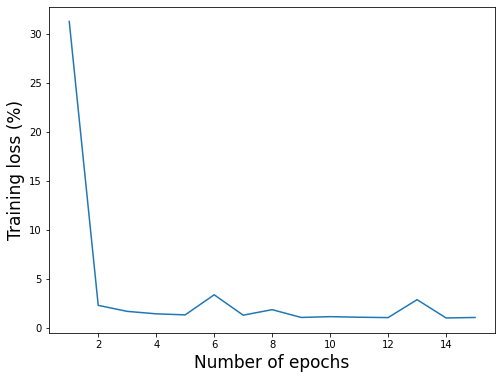

In [17]:
from matplotlib import pyplot as plt

f = plt.figure()
f.set_figwidth(8)
f.set_figheight(6)
plt.xlabel("Number of epochs", fontsize = 17)
plt.ylabel("Training loss (%)", fontsize = 17)


plt.plot(ep, tr_loss)
plt.show()

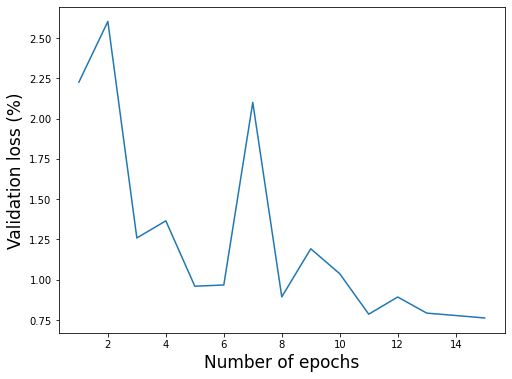

In [18]:
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(6)
plt.xlabel("Number of epochs", fontsize = 17)
plt.ylabel("Validation loss (%)", fontsize = 17)


plt.plot(ep, va_loss)
plt.show()

In [19]:

# Pkl_Filename = "transformerUnet_15ep_bs1.pkl"  

# with open(Pkl_Filename, 'wb') as file:  
#     pickle.dump(model, file)

In [13]:
with open('transformerUnet_15ep_bs1.pkl', 'rb') as file:  
    model = pickle.load(file)

In [17]:
def collate_test(batch):

    # Last 10 frames are target
    target = np.array(batch)[:,16:]                     
    
    # Add channel dim, scale pixels between 0 and 1, send to GPU
    batch = torch.tensor(batch).unsqueeze(1)          
    batch = batch / 255.0                             
    batch = batch.to(device)                          
    return batch, target

# Test Data Loader
test_loader = DataLoader(test_data,shuffle=True, 
                         batch_size=3, collate_fn=collate_test)


# Get a batch
batch, target = next(iter(test_loader))

In [18]:
# Initialize output sequence
output = np.zeros(target.shape, dtype=np.uint8)
for timestep in range(target.shape[1]):
    input = batch[:,:,timestep:timestep+16]
    input = torch.squeeze(input,dim=1)
    op = model(input.to(device))
    op = torch.mean(op, 1)
    batch[:,:,timestep+16] = torch.unsqueeze(op, dim=1)
    output[:,timestep]=(op.cpu()>0.1)*255.0

In [19]:
for tgt, out in zip(target, output):       # Loop over samples
    
    # Write target video as gif
    with io.BytesIO() as gif:
        imageio.mimsave(gif, tgt, "GIF", fps = 2)    
        target_gif = gif.getvalue()

    # Write output video as gif
    with io.BytesIO() as gif:
        imageio.mimsave(gif, out, "GIF", fps = 2)    
        output_gif = gif.getvalue()

    display(HBox([widgets.Image(value=target_gif, height=400, width=400), 
                  widgets.Image(value=output_gif, height=400, width=400)]))

In [63]:
test_loader_nu = DataLoader(test_data, shuffle=True, 
                        batch_size=1, collate_fn=collate)

ssim_test = 0
psnr_test = 0

model.eval()                                                   
with torch.no_grad():                                          
    for input, target in test_loader_nu:  
        input = np.squeeze(input, axis=1)
        output = model(input)   
        output = torch.mean(output, 1)
        output = torch.unsqueeze(output, dim=1) 
        psnr_test+=calculate_psnr(target, output)
        ot = output.flatten().cpu()
        tt = target.flatten().cpu()
        ssim_test+=ssim(ot.detach().numpy(), tt.detach().numpy())
psnr_test/= len(test_loader_nu.dataset)
ssim_test/=len(test_loader_nu.dataset)


In [64]:
print("PSNR for test dataset: {:.8f}".format(psnr_test.item()))
print("SSIM for test dataset: {:.8f}".format(ssim_test))

PSNR for test dataset: 47.66781998
SSIM for test dataset: 0.99428041
